In [2]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.anBiGLasso_cov import anBiGLasso
from Scripts.EiGLasso import EiGLasso_cov as EiGLasso
from Scripts.scBiGLasso import scBiGLasso_cov as scBiGLasso
from Scripts.utilities import binarize_matrix

In [5]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Mouse Embryonic Stem Cell Data
Data from paper "Computational analysis of cell-to-cell heterogeneity in single-cell RNA-sequencing data reveals hidden subpopulations of cells" by Buettner et al.
https://www.nature.com/articles/nbt.3102#accession-codes

Specifically, downloaded from here (the 'processed data'):
https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-2805

We use the same genes as used in the scBiGLasso paper - in the file `Nmythosis.txt`

In [7]:
# Read the data
mitosis_genes = pd.read_csv('../../Data/Nmythosis.txt')
G1_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G1_singlecells_counts.txt',
    sep='\t'
).dropna()
G2M_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/G2M_singlecells_counts.txt',
    sep='\t'
).dropna()
S_df = pd.read_csv(
    '../../Data/E-MTAB-2805.processed.1/S_singlecells_counts.txt',
    sep='\t'
).dropna()
G1_df = G1_df[G1_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
G2M_df = G2M_df[G2M_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
S_df = S_df[S_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]

In [8]:
# Get matrix of counts
# (transpose needed to mimic scBiGLasso)
G1_mat = G1_df.iloc[:, 4:].to_numpy()
G2M_mat = G2M_df.iloc[:, 4:].to_numpy()
S_mat = S_df.iloc[:, 4:].to_numpy()
counts = np.concatenate([S_mat, G1_mat, G2M_mat], axis=1).T[np.newaxis, ...]

In [231]:
# Transform to gaussian
T, S = nonparanormal_skeptic(counts)

## scBiGLasso

In [ ]:
# Takes too long to work
Psi, Theta = scBiGLasso(500, 10e-4, T, S, beta_1 = 0.2, beta_2 = 0.2)

In [ ]:

Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


## EiGLasso

In [234]:
Psi, Theta = EiGLasso(T, S, beta_1 = 0.4, beta_2 = 0.4)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


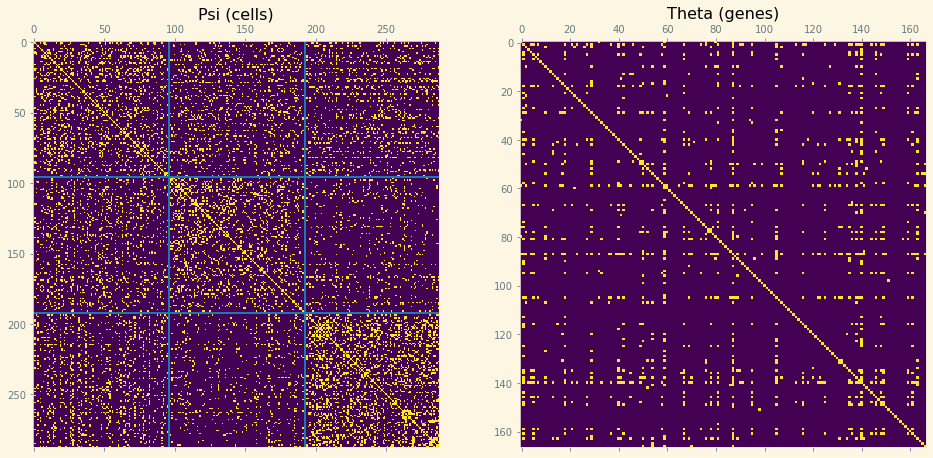

In [235]:

Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")


## anBiGLasso

In [461]:
# Calculate precision matrices
Psi, Theta = anBiGLasso(T, S, beta_1=0.00002, beta_2=0.000001, B_approx_iters=10)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


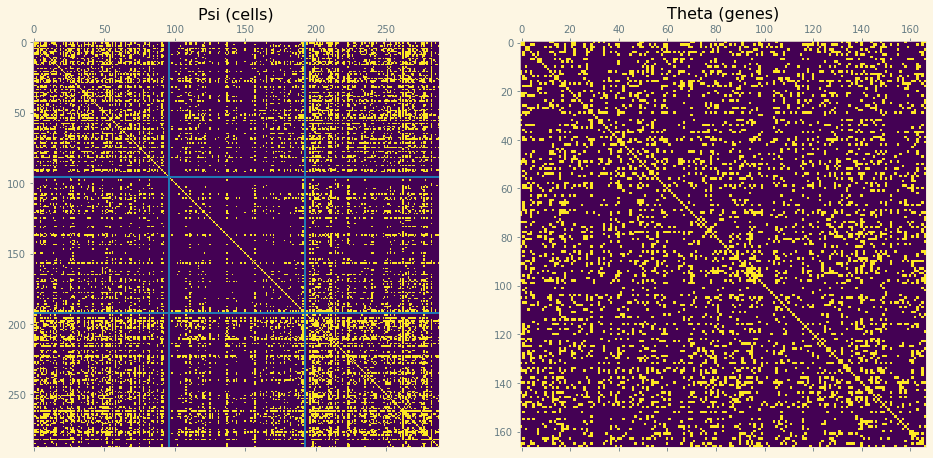

In [462]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

# EiGLasso with anBiGLasso initialization
Note: this code requires modifying the EiGLasso code to accept custom
initialization parameters.

In [434]:
Psi, Theta = anBiGLasso(T, S, beta_1=0, beta_2=0)

print(Psi)
Psi, Theta = EiGLasso(
    T,
    S,
    beta_1=0.4,
    beta_2=0.4,
    Psi_init=Psi,
    Theta_init=Theta
)
print(Psi)

[[ 0.054  0.001 -0.002 ...  0.     0.     0.003]
 [ 0.001  0.113  0.001 ... -0.01   0.004 -0.001]
 [-0.002  0.001  0.081 ... -0.002  0.006  0.   ]
 ...
 [ 0.    -0.01  -0.002 ...  0.088 -0.006  0.007]
 [ 0.     0.004  0.006 ... -0.006  0.085 -0.011]
 [ 0.003 -0.001  0.    ...  0.007 -0.011  0.106]]
[[ 0.09   0.001 -0.002 ...  0.     0.     0.003]
 [ 0.001 -0.103  0.001 ... -0.023  0.004 -0.002]
 [-0.002  0.001  0.048 ... -0.002  0.006  0.   ]
 ...
 [ 0.    -0.023 -0.002 ...  0.097 -0.006  0.007]
 [ 0.     0.004  0.006 ... -0.006  0.048 -0.026]
 [ 0.003 -0.002  0.    ...  0.007 -0.026 -0.07 ]]


S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


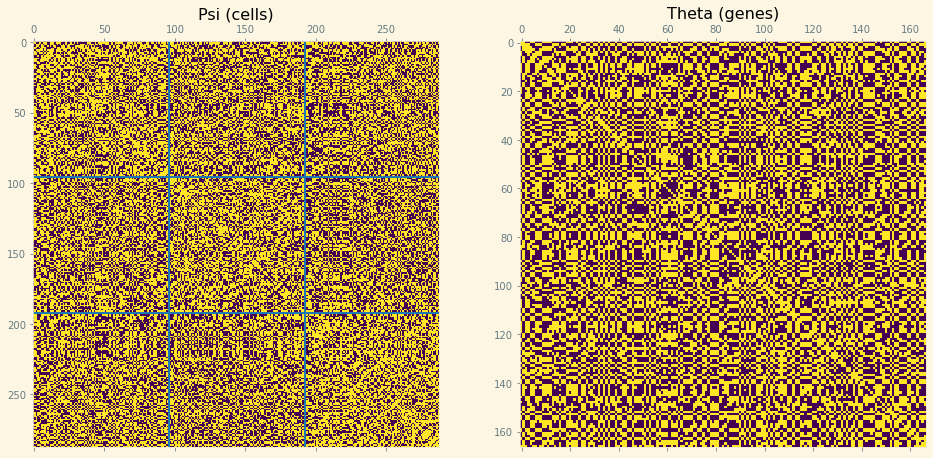

In [435]:
Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")

# anBiGLasso with augmented data

In [137]:
counts_ = counts.copy()
counts_.shape

(1, 288, 167)

In [138]:
counts_aug = counts_ + np.zeros((50, 288, 167), dtype='int64')
counts_aug.shape

(50, 288, 167)

In [173]:
library_means_1 = counts_aug.mean(axis=1, keepdims=True)
random_modification_1 = np.random.random(counts_aug.shape) * library_means_1 / 2
library_means_2 = counts_aug.mean(axis=2, keepdims=True)
random_modification_2 = np.random.random(counts_aug.shape) * library_means_2 / 2

In [444]:
# Transform to gaussian
T, S = nonparanormal_skeptic(counts_aug + random_modification_1 + 0 * random_modification_2)

In [445]:
# Calculate precision matrices 
Psi, Theta = anBiGLasso(T, S, beta_1=0.00003, beta_2=0.000005, B_approx_iters=10)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 287


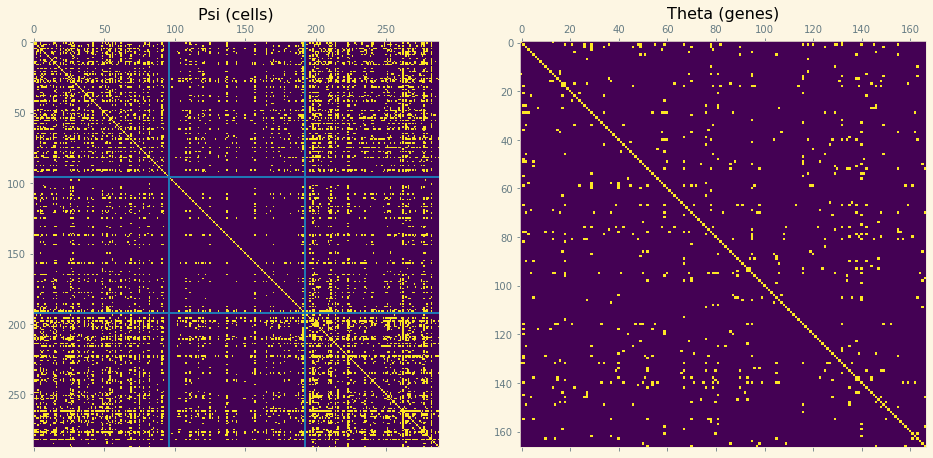

In [446]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax1.axvline(S_mat.shape[1])
    ax1.axvline(S_mat.shape[1]+G1_mat.shape[1])
    ax1.axhline(S_mat.shape[1])
    ax1.axhline(S_mat.shape[1]+G1_mat.shape[1])
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]-1}")